# K-Means реализация в scikit-learn

## Содержание
* [Использование K-Means из библиотеки sklearn](#sklearn)
    * [Загрузка данных](#read_data)
    * [Анализ данных](#analisys)
    * [Построение модели](#modeling)
* [Поиск оптимального количества кластеров](#clusters)
    * [1. Знание данных (Domain Knowledge)](#domain)
    * [2. Эмпирическое первое приближение (Rule of Thumb) ](#thumb)
    * [3. Метод локтя (Elbow-Method)](#elbow)
    * [4. Качество кластеризации с использованием Силуэта (Silhouette Score)](#silhouette)
* [Пример с другими измерениями и использование всех данных](#3d)
* [Ограничения метода](#limits)
    * [1. Метод не гарантирует нахождение глобального минимума](#dis1)
    * [2. Чувствительность к начальным условиям](#dis2)
    * [3. Количество кластеров необходимо подбирать руками.](#dis3)
    * [4. Метод является линейным](#dis4)
    * [5. Прочее](#dis6)
* [Сложность алгоритма](#complexity)
* [Применения K-Means](#usage)
* [Когда использовать K-Means](#howto)
* [Полезные ссылки](#links)


## Использование K-Means из библиотеки sklearn <a class="anchor" id="sklearn"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

In [2]:
colors = ['black', 'silver', 'darkred', 'coral', 'peru',
          'darkorange', 'darkgoldenrod', 'olive', 'darkseagreen', 'darkgreen',
          'green', 'lightseagreen', 'darkcyan', 'deepskyblue', 'steelblue',
          'royalblue', 'navy', 'plum', 'deeppink', 'pink'
         ]
colors = [mcolors.CSS4_COLORS[col] for col in colors]

def visualize_kmeans(alg, data, fields):
    plt.figure(figsize=(10,10))
    #Visualizing all the clusters
    color_inds = np.random.randint(0, len(colors), size=len(colors))
    current_color_ind = 0
    y_pred = alg.predict(data)
    for clust in range(alg.n_clusters):
        ind = y_pred == clust
        plt.scatter(
            data.iloc[ind, 0],
            data.iloc[ind, 1],
            s = 100,
            c = list(colors)[current_color_ind],
            label = 'Cluster ' + str(clust)
        )
        current_color_ind+=1
    plt.scatter(
        alg.cluster_centers_[:, 0],
        alg.cluster_centers_[:, 1],
        s = 300,
        c = 'red',
        label = 'Centroids')
    plt.title('Clusters of customers')
    plt.xlabel(fields[0])
    plt.ylabel(fields[1])
    plt.legend()
    plt.show()

**Рассмотрим решение следующей задачи:**

Содержание данных
Вы - владелец супермаркета. У вас есть некоторые базовые данные о владельцах скидочных карт вашего магазина, такие как: ID пользователя, возраст, пол, годовой доход и оценка расходов.
Оценка расходов (Spending Score) - некоторая оценка пользователя на основании его поведения и чеков.

Идея - разделить пользователей на группы, чтобы затем использовать в отделе маркетинга (например, таргетированная реклама, скидуи и т.п.) с целью увеличения доходов от пользователей.

Используется датасет для учебных целей:
https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python/data

**Структура данных:**
 - CustomerId - уникальный идентификатор покупателя
 - Gender - пол покупателя
 - Age - возраст покупателя
 - Annual Income (k$) - годовой доход
 - Spending Score (1-100) - сколько денег потратил в супермаркете (отмасштабированный показатель)

### Загрузка данных <a class="anchor" id="read_data"></a>

In [3]:
# Sklearn realization on some dataset
data_df = pd.read_csv('customer-segmentation-tutorial-in-python.zip')
data_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Анализ данных <a class="anchor" id="analisys"></a>

Перед тем, как приступать к решению задачи, часто полезно сначала посмотреть на данные - во многих случаях, можно избежать ошибок заранее или найти некие неочевидные зависимости. Например;
1. стоит проверить типы данных (если есть категориальные переменные - их надо обрабатывать особым образом),
2. проверить распределения данных - могут быть сильные выбросы или распределение иметь необычную структуру (данные надо чистить и/или нормализовать/стандартизовать),
3. проверить пропуски в данных (наличие NULL - некоторые алгоритмы могут не запуститься, поскольку не определены операции работы с NULL)
4. проверить на корреляцию - для некоторых алгоритмов корреляция может испортить результаты, и почти всегда - лишние операции без прироста к точности.
5. посмотреть на данные, понять их природу - очень часто это позволяет изобрести новые признаки (Feature Engineering), которые могут дать значительный прирост к точности.

In [4]:
print('Размер датасета:', data_df.shape)
data_df.describe()

Размер датасета: (200, 5)


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Как мы видим, все типы являются числовыми, кроме пола - поле Gender.
Необходимо конвертировать его в числовой тип, поскольку KMeans не умеет работать с категориальными признаками (как для них вычислять дистанцию?)

In [5]:
data_df['Gender'] = data_df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [6]:
# Проверим, нет ли в данных пропусков:
data_df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Пропусков в данных нет - все строки заполнены числовыми значениями, причем даже нулевых значений нет.

In [7]:
# Посмотрим, какие уникальные значения бывают у возраста:
data_df['Age'].value_counts()

32    11
35     9
19     8
31     8
30     7
49     7
27     6
47     6
40     6
23     6
36     6
38     6
50     5
48     5
29     5
21     5
20     5
34     5
18     4
28     4
59     4
24     4
67     4
54     4
39     3
25     3
33     3
22     3
37     3
43     3
68     3
45     3
46     3
60     3
41     2
57     2
66     2
65     2
63     2
58     2
26     2
70     2
42     2
53     2
52     2
51     2
44     2
55     1
64     1
69     1
56     1
Name: Age, dtype: int64

In [8]:
# Аналогично посмотрим соотношение полов, например, в нормализованном виде:
print(data_df['Gender'].value_counts(normalize=True))

0    0.56
1    0.44
Name: Gender, dtype: float64


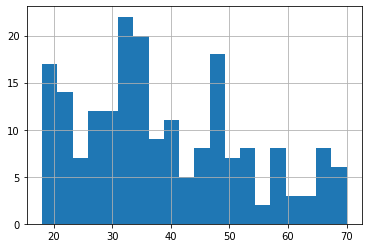

In [9]:
data_df['Age'].hist(bins=20)

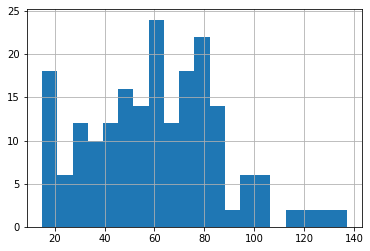

In [10]:
data_df['Annual Income (k$)'].hist(bins=20)

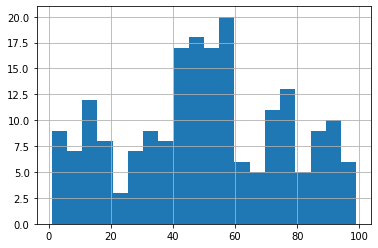

In [11]:
data_df['Spending Score (1-100)'].hist(bins=20)

Датасет достаточно чистый - не наблюдается сильных выбросов; распределения, конечно не нормальные, но без особых всплесков. Можно переходить к построению модели

### Построение модели <a class="anchor" id="modeling"></a>
Для наглядности, сначала мы построим кластеризацию, используя только 2 признака - чтобы можно было удобно визуализировать.

Inertia: 5226.669302919303
Num of iterations: 8


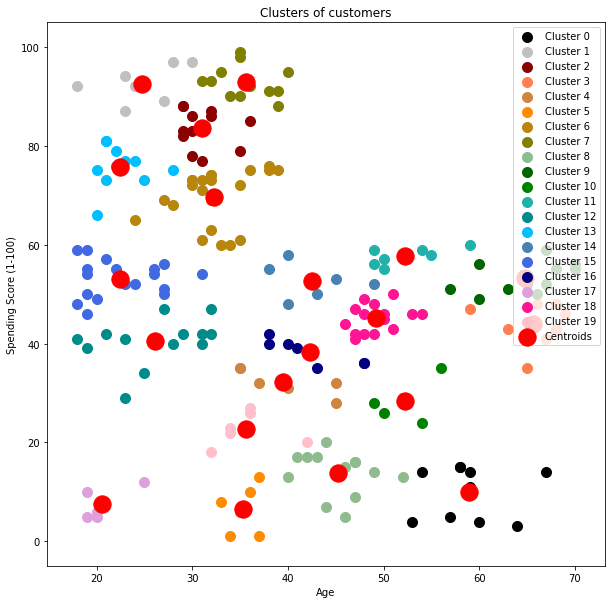

In [12]:
columns = [2,4]
# columns = [3,4]
fields_names = data_df.columns[columns].to_numpy()
X = data_df.iloc[:, columns]
kmeans_alg = KMeans(n_clusters= 20, n_init=10, init='random', random_state=42)
prediction = kmeans_alg.fit_predict(X)

print('Inertia:', kmeans_alg.inertia_)
print('Num of iterations:', kmeans_alg.n_iter_)
visualize_kmeans(kmeans_alg, X, fields=fields_names)

Кластеризация работает, но количество кластеров выбрано плохо!

## Поиск оптимального количества кластеров <a class="anchor" id="clusters"></a>
Метод K-Means не имеет встроенного инструмента для поиска необходимого количества кластеров. Существует ряд способов, как можно оценить оптимальное количество кластеров:


### 1. Знание данных (Domain Knowledge) <a class="anchor" id="domain"></a>
Наиболее распространенный метод, основанный на некоем знании аналитика о предметной области решаемой задачи. При решении прикладных задач аналитик разбирается в данных, понимает их происхождение, как они собраны и что обозначают. Подобные знания могут диктовать логичное объяснение выбора количества кластеров (например, при рекомендации размеров одежды, мы можем заранее предположить, что их количество, скажем, 5 S/M/L/XL/XXL). Помимо этого, сама постановка задачи может содержать требования к количеству кластеров - например, если бизнес-заказчик хочет разделить всех пользователей по возможной маржинальности high/Medium/Low

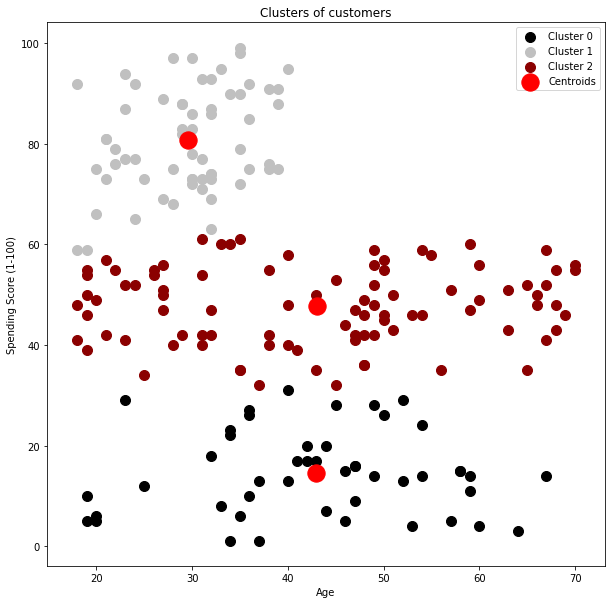

In [13]:
# предположим, что количество кластеров - 3: кто тратит мало, средне и много:
kmeans_alg = KMeans(n_clusters= 3, n_init=10, init='random', random_state=42)
prediction = kmeans_alg.fit_predict(X)
visualize_kmeans(kmeans_alg, X, fields=fields_names)
# не очень-то нам помогло знание предметной области - кластера сложно интерпретировать.

### 2. Эмпирическое первое приближение (Rule of Thumb) <a class="anchor" id="thumb"></a>
Используется, если из знания о предметной области невозможно предположить, сколько должно быть кластеров. Это довольно грубое правило, которое можно использовать лишь в качестве начального приближения. Редко когда срабатывает хорошо.
$$k = \sqrt{ \frac{n}{2} }$$

В нашем случае
$$k = \sqrt{ \frac{200}{2} } = 10$$

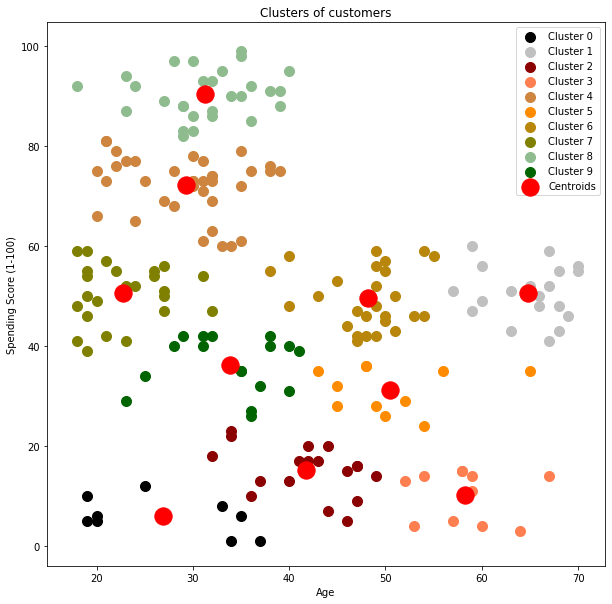

In [14]:
# в нашем случае k = 10
kmeans_alg = KMeans(n_clusters= 10, n_init=10, init='random', random_state=42)
prediction = kmeans_alg.fit_predict(X)
visualize_kmeans(kmeans_alg, X, fields=fields_names)
# не очень-то нам помогло знание предметной области - кластера сложно интерпретировать.

### 3. Метод локтя (Elbow-Method) <a class="anchor" id="elbow"></a>
Наиболее распространенный и устройчивый метод. Идея заключается в оценке скорости изменения метрики качества. В качестве метрики качества обычно (по умолчанию в K-Means реализации sklearn) используется WCSS - Within-Cluster-Sum-of-Squares, т.е. сумма дистанций от каждой точки до центроида кластера.
$$WCSS  = \sum_{i \in n}^{}(X_i - C_i)^2,$$
где $C_i$ - координаты центроида кластера, к которому относится $X_i$ 

Идея метода заключается в том, что обычно скорость уменьшения значения метрики уменьшается при увеличении кластеров. И имеет смысл выбирать такое количество кластеров, когда скорость изменения метрики значительно изменяется.

Т.е. для кода снизу: разница в изменении метрики для 1 кластера и 2 колоссальна. Между 2 и 3 - также значительна. А вот 7 или 8 - разницы уже почти нет, что говорит о том, что метод уже начинает дробить на кластера точки, которые и так находятся рядом.

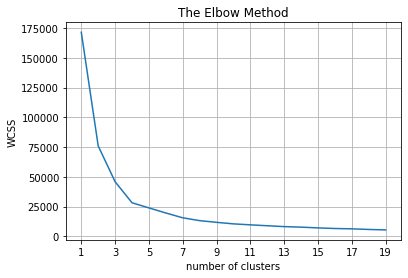

In [15]:
WCSS = []
max_num = 20
for num in range(1,max_num):
    kmeans_alg = KMeans(n_clusters= num, n_init=10, init='random', random_state=42)
    prediction = kmeans_alg.fit_predict(X)
    WCSS.append(kmeans_alg.inertia_)

plt.plot(range(1,max_num), WCSS)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1,max_num,2))
plt.grid()
plt.show()

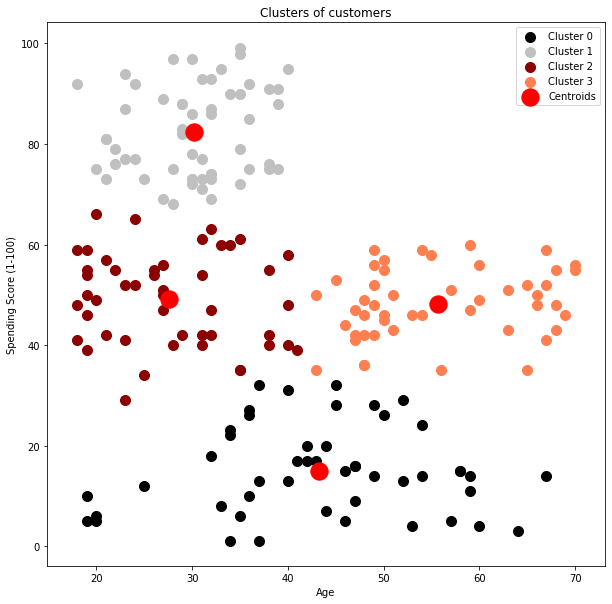

In [16]:
# По графику выглядит оптимальным 4-7 кластеров
kmeans_alg = KMeans(n_clusters= 4, n_init=10, init='random', random_state=42)
prediction = kmeans_alg.fit_predict(X)
visualize_kmeans(kmeans_alg, X, fields=fields_names)

### 4. Качество кластеризации с использованием Силуэта (Silhouette Score) <a class="anchor" id="silhouette"></a>
Silhouette Score - одна из метрик качества кластеризации, которая может быть применена не только к K-Means методу.
$$S_{score} = \frac {\sum_{i \in n}{SC_i}}{n},$$
где
$SC$ - Silhouette Coefficient:
$$SC_i = \frac {(b - a)}{max(a, b)},$$
где

$a$ - mean intra-cluster distance, среднее расстояние до точек этого же кластера,

$b$ - nearest-cluster distance, расстояние от рассматриваемой точки до ближайшего кластера, членом которого данная точка не является

Стоит отметить, что силуэт можно рассчитать только в случае, если количество кластеров больше 1, но меньше, чем количество точек (иначе не может рассчитать дистанцию до ближайшего другого кластера):
$$2 <= n_{labels} <= n_{samples} - 1$$


Подробный пример использования силуэта можно найти здесь:

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

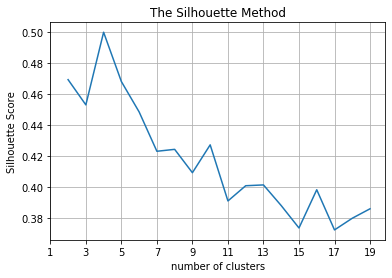

In [17]:
silhouette = []
max_num = 20
for num in range(2,max_num):
    kmeans_alg = KMeans(n_clusters= num, n_init=10, init='random', random_state=42)
    prediction = kmeans_alg.fit_predict(X)
    silhouette.append(silhouette_score(X, kmeans_alg.labels_))

plt.plot(range(2,max_num), silhouette)
plt.title('The Silhouette Method')
plt.xlabel('number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(1,max_num,2))
plt.grid()
plt.show()

Данный метод также рекомендует взять 4 кластера.

## Пример с другими измерениями и использование всех данных <a class="anchor" id="3d"></a>

Попробуем применить все новые знания для проверки на других двух измерениях - посмотрим, что получится, если будем кластеризовать данные, используя два других признака - годовой доход и покупательную способность.
Используем метод локтя с использованием суммарной дистанции и силуэта.

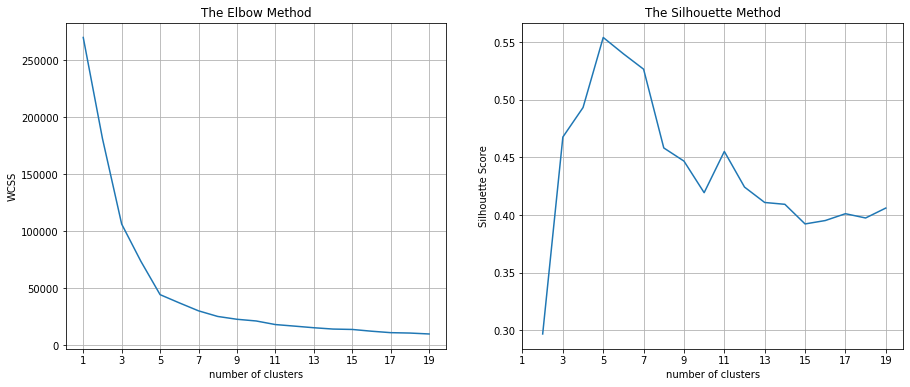

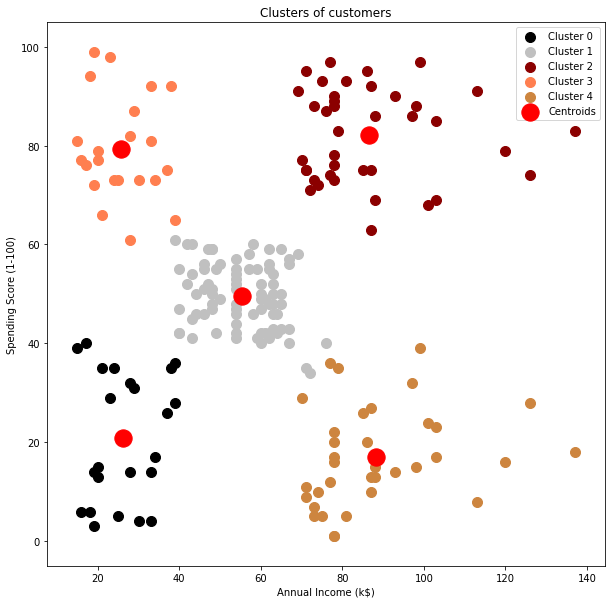

In [18]:
# columns = [2,4]
# Выбираем нужные признаки
columns = [3,4]
fields_names = data_df.columns[columns].to_numpy()
X = data_df.iloc[:, columns]

# Используем метод локтя с суммарной дистанцией
WCSS = []
max_num = 20
for num in range(1,max_num):
    kmeans_alg = KMeans(n_clusters= num, n_init=10, init='random', random_state=42)
    prediction = kmeans_alg.fit_predict(X)
    WCSS.append(kmeans_alg.inertia_)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), sharey=False)

ax1.plot(range(1,max_num), WCSS)
ax1.set_title('The Elbow Method')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('WCSS')
ax1.set_xticks(range(1,max_num,2))
ax1.grid()
# plt.show()

# Используем силуэт
silhouette = []
max_num = 20
for num in range(2,max_num):
    kmeans_alg = KMeans(n_clusters= num, n_init=10, init='random', random_state=42)
    prediction = kmeans_alg.fit_predict(X)
    silhouette.append(silhouette_score(X, kmeans_alg.labels_))

ax2.plot(range(2,max_num), silhouette)
ax2.set_title('The Silhouette Method')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(range(1,max_num,2))
ax2.grid()
plt.show()

# Визуализируем полученный результат для лучшего количества кластеров k=5
kmeans_alg = KMeans(n_clusters= 5, n_init=10, init='random', random_state=42)
prediction = kmeans_alg.fit_predict(X)
visualize_kmeans(kmeans_alg, X, fields=fields_names)

Все это время мы рассматривали по два признака из данных, чтобы можно было визуализировать и глазами оценить результаты. Попробуем теперь обучить модель с учетом всех признаков.

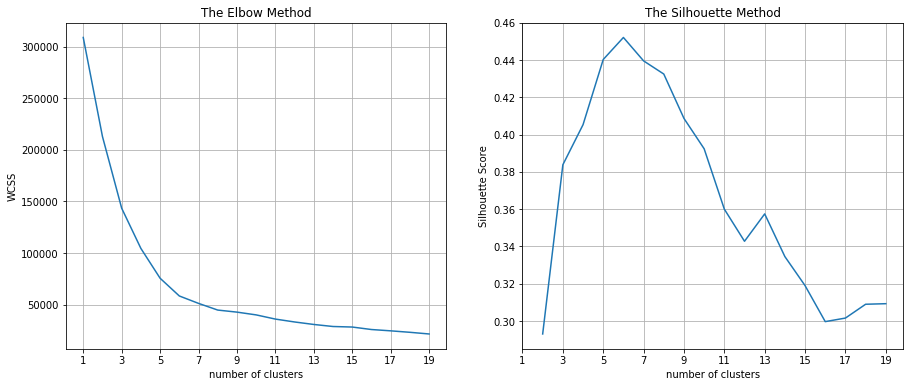

In [19]:
columns = [1,2,3,4]
fields_names = data_df.columns[columns].to_numpy()
X = data_df.iloc[:, columns]

WCSS = []
max_num = 20
for num in range(1,max_num):
    kmeans_alg = KMeans(n_clusters= num, n_init=10, init='random', random_state=42)
    prediction = kmeans_alg.fit_predict(X)
    WCSS.append(kmeans_alg.inertia_)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), sharey=False)

ax1.plot(range(1,max_num), WCSS)
ax1.set_title('The Elbow Method')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('WCSS')
ax1.set_xticks(range(1,max_num,2))
ax1.grid()
# plt.show()

silhouette = []
max_num = 20
for num in range(2,max_num):
    kmeans_alg = KMeans(n_clusters= num, n_init=10, init='random', random_state=42)
    prediction = kmeans_alg.fit_predict(X)
    silhouette.append(silhouette_score(X, kmeans_alg.labels_))

ax2.plot(range(2,max_num), silhouette)
ax2.set_title('The Silhouette Method')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(range(1,max_num,2))
ax2.grid()
plt.show()

<IPython.core.display.Javascript object>


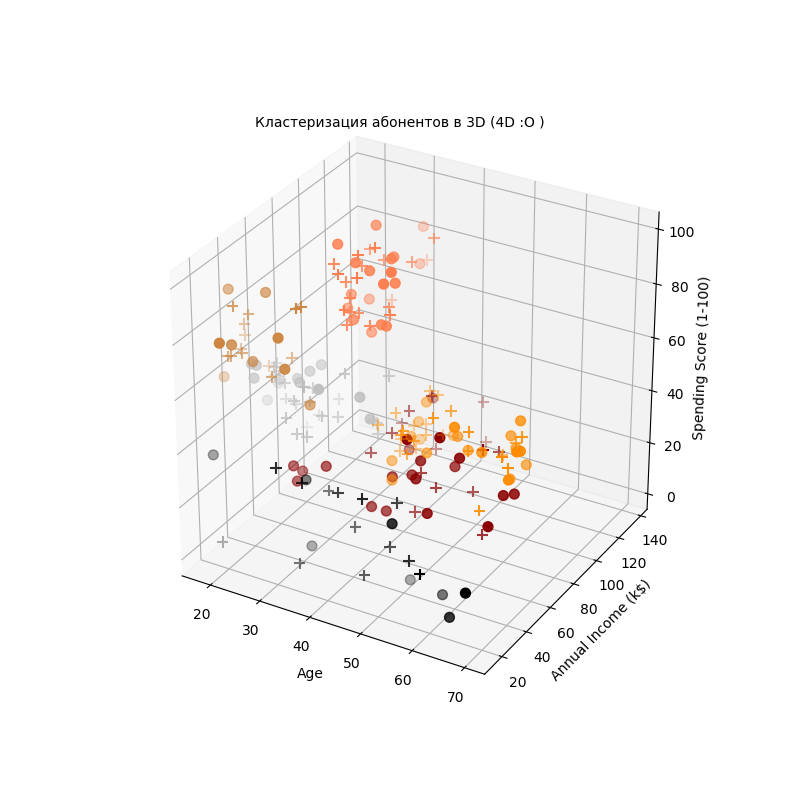

In [21]:
from mpl_toolkits import mplot3d
%matplotlib notebook

columns = [1,2,3,4]
fields_names = data_df.columns[columns].to_numpy()
X = data_df.iloc[:, columns]
kmeans_alg = KMeans(n_clusters= 6, n_init=10, init='random', random_state=42)
prediction = kmeans_alg.fit_predict(X)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for clust in np.unique(prediction):
    cur_color = colors[clust]
    current_clust = X.iloc[prediction==clust, :]
    cur_male = current_clust[current_clust['Gender'] == 1]
    cur_female = current_clust[current_clust['Gender'] == 0]
    ax.scatter(
        cur_male.iloc[:,1].to_numpy(),
        cur_male.iloc[:,2].to_numpy(),
        cur_male.iloc[:,3].to_numpy(),
        marker='o',
        c=cur_color,
        s=50,
    )
    ax.scatter(
        cur_female.iloc[:,1].to_numpy(),
        cur_female.iloc[:,2].to_numpy(),
        cur_female.iloc[:,3].to_numpy(),
        marker='+',
        c=cur_color,
        s=70,
    )
ax.set_xlabel(fields_names[1])
ax.set_ylabel(fields_names[2])
ax.set_zlabel(fields_names[3])
ax.text2D(0.25, 0.95, "Кластеризация абонентов в 3D (4D :O )", transform=ax.transAxes)
plt.show()
# plt.scatter(X.iloc[:,1:4].to_numpy())

## Ограничения метода <a class="anchor" id="limits"></a>

### 1. Метод не гарантирует нахождение глобального минимума <a class="anchor" id="dis1"></a>
Т.е. получение лучшего возможного решения не обязательно. например, даже если в данных присутсвует при кластера на самом деле, но они имеют разную дисперсию, метод справится плохо.

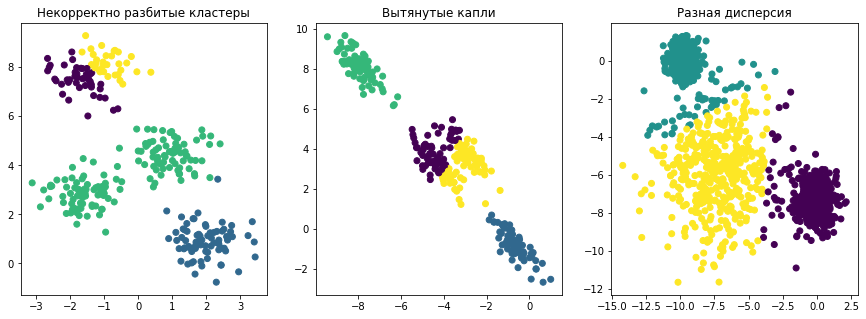

In [172]:
%matplotlib inline
plt.figure(figsize=(15, 5))
# Получение локального минимума
X, _ = make_blobs(
    n_samples=300,
    centers=4,
    cluster_std=0.60,
    random_state=0
)
prediction = KMeans(n_clusters=4, n_init=1, init='random', random_state=2).fit_predict(X)

plt.subplot(1,3,1)
plt.scatter(X[:, 0], X[:, 1], c=prediction); 
plt.title("Некорректно разбитые кластеры")


# Анизотропно распределенные данные
transformation = [[0.1, -0.8], [-1, 0.9]]
X_transformed = np.dot(X, transformation)
prediction = KMeans(n_clusters=4, random_state=42).fit_predict(X_transformed)

plt.subplot(1,3,2)
plt.title("Вытянутые капли")
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=prediction)

# Разная дисперсия данных
X_var, _ = make_blobs(
    n_samples=1500,
    centers=3,
    cluster_std=[0.5, 0.7, 2.3],
    random_state=9,
)
prediction = KMeans(n_clusters=3, n_init=1, random_state=42).fit_predict(X_var)

plt.subplot(1,3,3)
plt.scatter(X_var[:, 0], X_var[:, 1], c=prediction)
plt.title("Разная дисперсия")

plt.show()

### 2. Чувствительность к начальным условиям (например, rseed) <a class="anchor" id="dis2"></a>
Инициализация центров кластеров может значительно влиять на итоговый результат.
По этой причине хорошие реализации запускают метод несколько раз с различными начальными условиями

Помимо этого, можно задать гиперпараметр алгоритма `init=k-means++`

Сравнение различных методов инициализации центров кластеров:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py

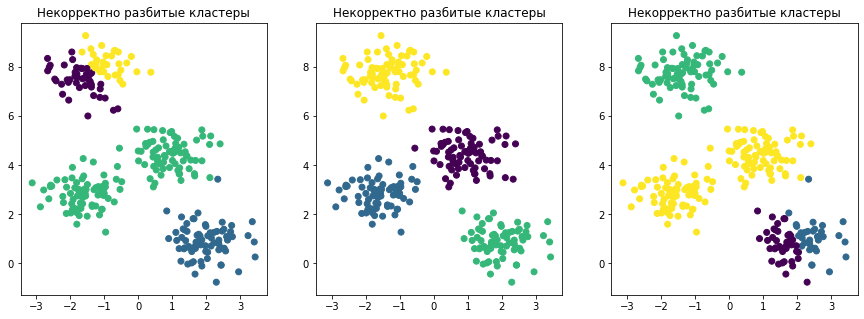

In [195]:
# Пример с различными начальными условиями
plt.figure(figsize=(15, 5))
# Получение локального минимума
X, _ = make_blobs(
    n_samples=300,
    centers=4,
    cluster_std=0.60,
    random_state=0
)
for ind, rand_state in enumerate([2,3,97]):
    prediction = KMeans(n_clusters=4, n_init=1, init='random', random_state=rand_state).fit_predict(X)
    plt.subplot(1,3,ind+1)
    plt.scatter(X[:, 0], X[:, 1], c=prediction); 
    plt.title("Некорректно разбитые кластеры")
plt.show()

### 3. Количество кластеров необходимо подбирать руками <a class="anchor" id="dis3"></a>
Для использования метода необходимо указывать, сколько кластеров он должен выделить. Сам метод определить оптимальное количество кластеров не способен - он будет находить столько кластеров, сколько мы указали, в любых данных. Для решения этой проблемы приходится считать с различным количеством кластеров и смотреть, как при этом меняются метрики качества. Есть ряд других методов кластеризации, которые способны определять количество кластеров самостоятельно.

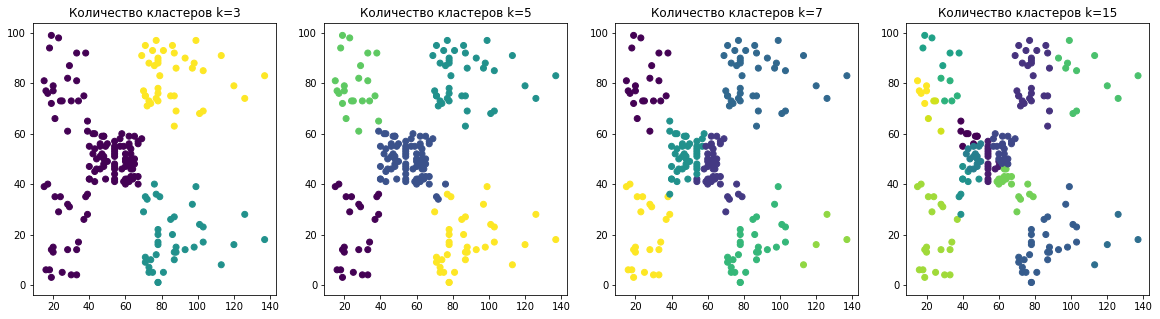

In [208]:
# Выбираем нужные признаки из нашего датасета
columns = [3,4]
fields_names = data_df.columns[columns].to_numpy()
X = data_df.iloc[:, columns]

num_clusters = [3,5,7,15]
plt.figure(figsize=(20, 5))
for ind, num in enumerate(num_clusters):
    prediction = KMeans(n_clusters=num, n_init=1, init='random', random_state=42).fit_predict(X)
    plt.subplot(1,len(num_clusters),ind+1)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=prediction); 
    plt.title(f"Количество кластеров k={num}")
plt.show()

### 4. Метод является линейным <a class="anchor" id="dis4"></a>
Поскольку метод считает расстояния от точки до центров кластеров, разделяющая линия между кластерами всегда будет прямой. Из-за этого, если облако точек имеет сложную геометрию, метод не сможет построить нелинейные границы между кластерами и разделить их хорошо.
Решением может быть переход к пространству большей размерности, в котором данные будут линейно-отделимы. Подобная реализация называется K-Means с ядром или Спектральная  кластеризация (Spectral Clustering)
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

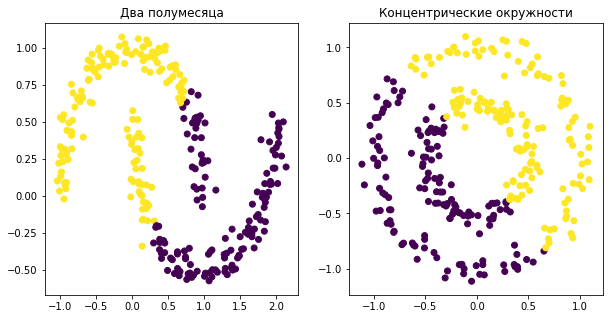

In [239]:
# Пример с полумесяцами
from sklearn.datasets import make_moons
plt.figure(figsize=(10, 5))
X_moons, _ = make_moons(300, noise=0.07)

prediction = KMeans(n_clusters=2, n_init=1, init='random', random_state=42).fit_predict(X_moons)
plt.subplot(1,2,1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=prediction)
plt.title("Два полумесяца")


from sklearn.datasets import make_circles
X_circles, _ = make_circles(n_samples=300, noise=0.07, factor=0.5)
prediction = KMeans(n_clusters=2, n_init=1, init='random', random_state=42).fit_predict(X_circles)
plt.subplot(1,2,2)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=prediction)
plt.title("Концентрические окружности")

plt.show()

from sklearn.datasets import make_biclusters

### 5. Прочее  <a class="anchor" id="dis5"></a>
 - Выбросы в данных могут "оттягивать" центроиды кластеров на себя, либо выброс может стать отдкльным кластером из одной точки (если достаточно много кластеров). Наблюдается регулярно при большом объеме данных - получается большое количество кластеров с малым количеством примеров в них. Решение: чистить датасет от выбросов перед кластеризацией. Либо рассматривать кластеры и объединять между собой...
 - При большом количестве измерений дистанция между любыми точками становится огромной. Дистанция начинает сходиться к константе. Метод начинает работать плохо. Решение: проводить уменьшение размерности.

## Сложность алгоритма <a class="anchor" id="complexity"></a>
Каждая итерация алгоримта состоит из двух шагов (N - количество точек, K - количество кластеров)
 - присвоение каждой точки одному из центров: O(NK)
 - изменение центра кластера: O(N)

Средняя сложность алгоритма составляет О(KNT) N - количество примеров, T - количество итераций.
Максимальная сложность алгоритма $O(N^{K+2/p})$, p - количество признаков.

Чем больше точек, тем больше дистанций надо рассчитывать. Это приводиит к росту вычислительной сложности. Решением этой проблемы становится использование подвыборок данных (mini batch), например, - `MiniBatchKMeans`.
Сравнение KMeans и MiniBatch KMeans:
https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/
https://www.researchgate.net/profile/Ali_Feizollah/publication/268386465_Comparative_Study_of_K-means_and_Mini_Batch_K-_means_Clustering_Algorithms_in_Android_Malware_Detection_Using_Network_Traffic_Analysis/links/5469d5680cf2f5eb18052107/Comparative-Study-of-K-means-and-Mini-Batch-K-means-Clustering-Algorithms-in-Android-Malware-Detection-Using-Network-Traffic-Analysis.pdf

**Стоит при этом отметить, что современные реализации (т.е. если не писать самому) K-Means очень быстрые. На текущий момент является одним из самых быстрых алгоритмов:**
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


## Применения K-Means  <a class="anchor" id="usage"></a>
1. **Color Compression**: https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py
Уменьшаем количество используемых цветов изображения с 96,615 до 64, стараясь сохранить визуальное качество
Есть еще более потрясающий пример на этом же изображении - уменьшаем количество цветов с 16 миллионов до 16 !!
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html#Example-2:-k-means-for-color-compression
На этом принципе можно реализовать простую **сегментацию изображений**:
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html


2. **Vector Quantization**: https://scikit-learn.org/stable/auto_examples/cluster/plot_face_compress.html#sphx-glr-auto-examples-cluster-plot-face-compress-py
Сжимаем изображение


3. **Document Clustering**: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
Кластеризация документов по темам


4. **MNIST clustering**: https://github.com/Datamine/MNIST-K-Means-Clustering/blob/master/Kmeans.ipynb 
Кластеризация изображений рукописных цифр


5. **Clustering to Gene Expression Data** https://scholarworks.lib.csusb.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1293&context=etd
Научная работа по экспресси генов, в которой используется k-Means


6. **Кластеризация новостей** https://seangtkelley.me/blog/2018/01/03/news-article-clustering 


7. **Классический пример с кластеризацией ирисов** https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py


## Когда использовать <a class="anchor" id="howto"></a>
1. Если датасет не имеет разметки
2. Когда все данные - числовые (numeric). Метод не умеет работать с категориальными данными, потомоу что не умеет вычислять дистанцию между ними
3. Самый простой метод кластеризации. Почти в любой задаче кластеризации, стоит начинать с использования этого метода в качестве базового решения (base-line)
4. Если есть предположение, сколько кластеров должно быть

## Полезные ссылки <a class="anchor" id="links"></a>

1. Хорошая анимация, как работает K-Means http://shabal.in/visuals/kmeans/1.html
2. Наглядное сравнение большого количества различных алгоритмов кластеризации https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
3. Удобная библиотека для визуализации результатов кластеризации yellowbrick https://www.scikit-yb.org/en/latest/api/cluster/icdm.html

C:\ProgramData\Anaconda3\envs\fraud_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


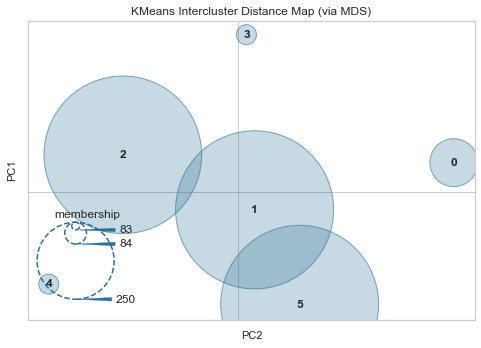

In [242]:
from yellowbrick.cluster import InterclusterDistance

# Generate synthetic dataset with 12 random clusters
X, y = make_blobs(n_samples=1000, n_features=12, centers=12, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure